In [34]:
# import relevant libraries
import re
import nltk
import string
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
%matplotlib inline

In [35]:
# 1. open the CSV files using a Pandas dataframe

df = pd.read_csv("earningscalls.csv")
df.head()

,Ticker,Date,5 Days Ahead,Pre-ECD,Start Price,End Price,Return,Return or not to Return
0,AAPL,1/29/19,2/3/19,1/28/19,156.30,171.25,9.56%,1
1,ATTO,3/20/19,3/25/19,3/19/19,3.94,3.39,-13.96%,0
2,CAG,3/21/19,3/26/19,3/20/19,22.90,27.12,18.43%,1
3,CCRO3,3/22/19,3/26/19,3/21/19,12.30,11.75,-4.47%,0
4,CSIQ,3/21/19,3/26/19,3/20/19,23.62,18.20,-22.95%,0


In [36]:
# 2. Create a new column where the date column in your CSV is 
# transformed to a Pandas datetime object
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')
df.head()

,Ticker,Date,5 Days Ahead,Pre-ECD,Start Price,End Price,Return,Return or not to Return
0,AAPL,2019-01-29,2/3/19,1/28/19,156.30,171.25,9.56%,1
1,ATTO,2019-03-20,3/25/19,3/19/19,3.94,3.39,-13.96%,0
2,CAG,2019-03-21,3/26/19,3/20/19,22.90,27.12,18.43%,1
3,CCRO3,2019-03-22,3/26/19,3/21/19,12.30,11.75,-4.47%,0
4,CSIQ,2019-03-21,3/26/19,3/20/19,23.62,18.20,-22.95%,0


In [37]:
# Instructions 3 and 4 require us to create new columns where we
# lower case and filter out things from the text, and also create another
# column where we tokenize, lemmatize, and remove stop words.

# Our earnings calls transcripts are super long so excel wouldn't let us
# paste in the transcript. Therefore we will read in these transcripts
# from txt files, add them into the dataframe and then continue on

# This is the function we will be using in order to pull the info 
# from the txt files.

def get_txt(ticker):
    file = open(ticker+".txt", "r", encoding="ISO-8859-1")
    ret = ''
    for line in file:
        ret+=line
    return ret

# This is us adding it in as a column to the dataframe
df['transcript'] = [get_txt(tick) for tick in df['Ticker']]
df.head()

,Ticker,Date,5 Days Ahead,Pre-ECD,Start Price,End Price,Return,Return or not to Return,transcript
0,AAPL,2019-01-29,2/3/19,1/28/19,156.30,171.25,9.56%,1,"OPERATOR: Good day, and welcome to the Apple Inc. First Quarter Fiscal Year 2019 Earnings Conference Call. Today's call is being recorded. At this..."
1,ATTO,2019-03-20,3/25/19,3/19/19,3.94,3.39,-13.96%,0,"LP \nPresentation\n\nOPERATOR: Greetings, and welcome to the Atento S.A. Fourth Quarter 2018 Earnings Results Call. (Operator Instructions) As a r..."
2,CAG,2019-03-21,3/26/19,3/20/19,22.90,27.12,18.43%,1,"LP \nPresentation\n\nOPERATOR: Good morning, ladies and gentlemen, and welcome to the Conagra Brands Third Quarter Fiscal Year 2019 Earnings Confe..."
3,CCRO3,2019-03-22,3/26/19,3/21/19,12.30,11.75,-4.47%,0,"LP \nPresentation\n\nOPERATOR: Good afternoon, ladies and gentlemen, thank you for waiting. We would like to welcome everyone to the Fourth Quarte..."
4,CSIQ,2019-03-21,3/26/19,3/20/19,23.62,18.20,-22.95%,0,"Prepared Remarks:\nOperator\nLadies and gentlemen, thank you for standing by. Welcome to Canadian Solar's Fourth Quarter 2018 Earnings Conference ..."


In [38]:
# Pythonic functional programming via lambda used for filtering text

df['clean_transcript'] = df.transcript.apply(lambda text: re.sub("'|\.|\s+|\d+|[^a-zA-Z0-9]"," ", text).lower())
df.head()

,Ticker,Date,5 Days Ahead,Pre-ECD,Start Price,End Price,Return,Return or not to Return,transcript,clean_transcript
0,AAPL,2019-01-29,2/3/19,1/28/19,156.30,171.25,9.56%,1,"OPERATOR: Good day, and welcome to the Apple Inc. First Quarter Fiscal Year 2019 Earnings Conference Call. Today's call is being recorded. At this...",operator good day and welcome to the apple inc first quarter fiscal year earnings conference call today s call is being recorded at this ti...
1,ATTO,2019-03-20,3/25/19,3/19/19,3.94,3.39,-13.96%,0,"LP \nPresentation\n\nOPERATOR: Greetings, and welcome to the Atento S.A. Fourth Quarter 2018 Earnings Results Call. (Operator Instructions) As a r...",lp presentation operator greetings and welcome to the atento s a fourth quarter earnings results call operator instructions as a reminder ...
2,CAG,2019-03-21,3/26/19,3/20/19,22.90,27.12,18.43%,1,"LP \nPresentation\n\nOPERATOR: Good morning, ladies and gentlemen, and welcome to the Conagra Brands Third Quarter Fiscal Year 2019 Earnings Confe...",lp presentation operator good morning ladies and gentlemen and welcome to the conagra brands third quarter fiscal year earnings conference ca...
3,CCRO3,2019-03-22,3/26/19,3/21/19,12.30,11.75,-4.47%,0,"LP \nPresentation\n\nOPERATOR: Good afternoon, ladies and gentlemen, thank you for waiting. We would like to welcome everyone to the Fourth Quarte...",lp presentation operator good afternoon ladies and gentlemen thank you for waiting we would like to welcome everyone to the fourth quarter e...
4,CSIQ,2019-03-21,3/26/19,3/20/19,23.62,18.20,-22.95%,0,"Prepared Remarks:\nOperator\nLadies and gentlemen, thank you for standing by. Welcome to Canadian Solar's Fourth Quarter 2018 Earnings Conference ...",prepared remarks operator ladies and gentlemen thank you for standing by welcome to canadian solar s fourth quarter earnings conference call ...


In [39]:
lemmatizer = WordNetLemmatizer()

sw = stopwords.words('english')
custom = ['.com','k','q','td','lp','u','qu','g','t','xs','xr','ir','id','d','i']

def get_wordnet_pos(tag):
    # Return whether "tag" is adjective,
    # noun, verb or adverb
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
        
def tokenize_lemmatize_stop_words(text):
    tokens = list(filter(lambda word: word not in sw and word !="", text.split(" "))) #tokened
    tokenized_pos = nltk.pos_tag(tokens)
    tokens_lemmatized = [lemmatizer.lemmatize(word,get_wordnet_pos(tag)) for word,tag in tokenized_pos]
    processed = list(filter(lambda word: word not in custom, tokens_lemmatized))
    return processed

df['nice_list'] = df.clean_transcript.apply(lambda text: tokenize_lemmatize_stop_words(text))
df['nice_sentence'] = df.nice_list.apply(lambda tokens_list: " ".join(tokens_list))

# pd.options.display.max_colwidth = 150
df.head()

,Ticker,Date,5 Days Ahead,Pre-ECD,Start Price,End Price,Return,Return or not to Return,transcript,clean_transcript,nice_list,nice_sentence
0,AAPL,2019-01-29,2/3/19,1/28/19,156.30,171.25,9.56%,1,"OPERATOR: Good day, and welcome to the Apple Inc. First Quarter Fiscal Year 2019 Earnings Conference Call. Today's call is being recorded. At this...",operator good day and welcome to the apple inc first quarter fiscal year earnings conference call today s call is being recorded at this ti...,"[operator, good, day, welcome, apple, inc, first, quarter, fiscal, year, earnings, conference, call, today, call, recorded, time, open, remark, in...",operator good day welcome apple inc first quarter fiscal year earnings conference call today call recorded time open remark introduction would lik...
1,ATTO,2019-03-20,3/25/19,3/19/19,3.94,3.39,-13.96%,0,"LP \nPresentation\n\nOPERATOR: Greetings, and welcome to the Atento S.A. Fourth Quarter 2018 Earnings Results Call. (Operator Instructions) As a r...",lp presentation operator greetings and welcome to the atento s a fourth quarter earnings results call operator instructions as a reminder ...,"[presentation, operator, greeting, welcome, atento, fourth, quarter, earnings, result, call, operator, instruction, reminder, conference, record, ...",presentation operator greeting welcome atento fourth quarter earnings result call operator instruction reminder conference record would like turn ...
2,CAG,2019-03-21,3/26/19,3/20/19,22.90,27.12,18.43%,1,"LP \nPresentation\n\nOPERATOR: Good morning, ladies and gentlemen, and welcome to the Conagra Brands Third Quarter Fiscal Year 2019 Earnings Confe...",lp presentation operator good morning ladies and gentlemen and welcome to the conagra brands third quarter fiscal year earnings conference ca...,"[presentation, operator, good, morning, lady, gentlemen, welcome, conagra, brand, third, quarter, fiscal, year, earnings, conference, call, operat...",presentation operator good morning lady gentlemen welcome conagra brand third quarter fiscal year earnings conference call operator instruction pl...
3,CCRO3,2019-03-22,3/26/19,3/21/19,12.30,11.75,-4.47%,0,"LP \nPresentation\n\nOPERATOR: Good afternoon, ladies and gentlemen, thank you for waiting. We would like to welcome everyone to the Fourth Quarte...",lp presentation operator good afternoon ladies and gentlemen thank you for waiting we would like to welcome everyone to the fourth quarter e...,"[presentation, operator, good, afternoon, lady, gentlemen, thank, wait, would, like, welcome, everyone, fourth, quarter, earnings, conference, cal...",presentation operator good afternoon lady gentlemen thank wait would like welcome everyone fourth quarter earnings conference call ccr operator in...
4,CSIQ,2019-03-21,3/26/19,3/20/19,23.62,18.20,-22.95%,0,"Prepared Remarks:\nOperator\nLadies and gentlemen, thank you for standing by. Welcome to Canadian Solar's Fourth Quarter 2018 Earnings Conference ...",prepared remarks operator ladies and gentlemen thank you for standing by welcome to canadian solar s fourth quarter earnings conference call ...,"[prepared, remark, operator, lady, gentleman, thank, stand, welcome, canadian, solar, fourth, quarter, earnings, conference, call, name, ann, oper...",prepared remark operator lady gentleman thank stand welcome canadian solar fourth quarter earnings conference call name ann operator today time pa...


In [40]:
# Compute the TFIDF Matrix for the cleaned tokenized word column.
# What is the TF measure you are using?
# What is the IDF measure you are using?
# Which words have the highest TF, IDF, and TF-IDF measure.

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['nice_sentence'])
tf = pd.DataFrame(columns=vectorizer.get_feature_names(), data=X.toarray())

tf.head()

,aaron,aaronbrothers,ab,abad,abandon,abate,abdalla,ability,able,abnormally,...,yttrium,yves,zachary,zack,zazove,zero,zinc,zinsner,zone,zoomx
0,0,0,0,0,0,0,0,1,2,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,12,0,0,0,1,3,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,3,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,3,1,4,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,2,1,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
vect2 = TfidfVectorizer()

Y = vect2.fit_transform(df['nice_sentence'])
tfidf = pd.DataFrame(columns=vect2.get_feature_names(), data=Y.toarray())

tfidf.head()

,aaron,aaronbrothers,ab,abad,abandon,abate,abdalla,ability,able,abnormally,...,yttrium,yves,zachary,zack,zazove,zero,zinc,zinsner,zone,zoomx
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.003490,0.006410,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.123201,0.0,0.0,0.00000,0.003794,0.010450,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.002282,0.006285,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.04075,0.005019,0.018433,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.006971,0.003200,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
print(tfidf.info(),"\n")
print("-----------------------------------------")
print("Shape :",tfidf.shape,"\n\n")
print("Size  :",tfidf.size,"Elements")
print("23 Rows * 5760 Cols =",23*5760,"\n")

print("\nTF Measures")
x_max,y_max = tf.stack().index[np.argmax(tf.values)]
x_min,y_min = tf.stack().index[np.argmin(tf.values)]
print("Max Word:",y_max,"\tValue:",tf.loc[x_max,y_max])
print("Min Word:",y_min,"Value:",tf.loc[x_min,y_min])

print("\n\nTF-IDF Measures")
x_max,y_max = tfidf.stack().index[np.argmax(tfidf.values)]
x_min,y_min = tfidf.stack().index[np.argmin(tfidf.values)]
print("Max Word:",y_max,"\tValue:",tfidf.loc[x_max,y_max])
print("Min Word:",y_min,"Value:",tfidf.loc[x_min,y_min])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Columns: 5760 entries, aaron to zoomx
dtypes: float64(5760)
memory usage: 1.0 MB
None 

-----------------------------------------
Shape : (23, 5760) 


Size  : 132480 Elements
23 Rows * 5760 Cols = 132480 


TF Measures
Max Word: year 	Value: 162
Min Word: aaron Value: 0


TF-IDF Measures
Max Word: eur 	Value: 0.6827464090603184
Min Word: aaron Value: 0.0


In [42]:
# Here is a chart showing the average word count per time period over time
# Was not sure what this meant
# time period would be 1 day
# count the average word count of the transcript per day? So if there are
# two earnings calls on Jan 1, and one has 5000 words, 
# and the other has 10000 words, return 7500 words.
df['word_count'] = [len(text.split(" ")) for text in df['clean_transcript']]
avg_word_count_df = df.groupby('Date').mean()['word_count']
avg_word_count_df

Date
2019-01-24     9978.000000
2019-01-29     9542.000000
2019-02-19    13772.000000
2019-02-28     9847.000000
2019-03-18     6407.000000
2019-03-19    11016.000000
2019-03-20     9554.400000
2019-03-21     8325.875000
2019-03-22     7558.666667
Name: word_count, dtype: float64

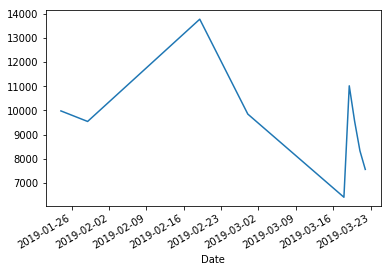

In [43]:
# Plotting average word count per day.
avg_word_count_df.plot()

In [44]:
# Perform 3 regex counts for at least 3 different tokens and plot the mean and median of this (per time period) over time.
re1 = "advantage"
re2 = "research"
re3 = "good"

df['re1'] = [len(re.findall(re1, el)) for el in df['clean_transcript']]
df['re2'] = [len(re.findall(re2, el)) for el in df['clean_transcript']]
df['re3'] = [len(re.findall(re3, el)) for el in df['clean_transcript']]
df.head()

,Ticker,Date,5 Days Ahead,Pre-ECD,Start Price,End Price,Return,Return or not to Return,transcript,clean_transcript,nice_list,nice_sentence,word_count,re1,re2,re3
0,AAPL,2019-01-29,2/3/19,1/28/19,156.30,171.25,9.56%,1,"OPERATOR: Good day, and welcome to the Apple Inc. First Quarter Fiscal Year 2019 Earnings Conference Call. Today's call is being recorded. At this...",operator good day and welcome to the apple inc first quarter fiscal year earnings conference call today s call is being recorded at this ti...,"[operator, good, day, welcome, apple, inc, first, quarter, fiscal, year, earnings, conference, call, today, call, recorded, time, open, remark, in...",operator good day welcome apple inc first quarter fiscal year earnings conference call today call recorded time open remark introduction would lik...,9542,0,13,5
1,ATTO,2019-03-20,3/25/19,3/19/19,3.94,3.39,-13.96%,0,"LP \nPresentation\n\nOPERATOR: Greetings, and welcome to the Atento S.A. Fourth Quarter 2018 Earnings Results Call. (Operator Instructions) As a r...",lp presentation operator greetings and welcome to the atento s a fourth quarter earnings results call operator instructions as a reminder ...,"[presentation, operator, greeting, welcome, atento, fourth, quarter, earnings, result, call, operator, instruction, reminder, conference, record, ...",presentation operator greeting welcome atento fourth quarter earnings result call operator instruction reminder conference record would like turn ...,8465,1,4,10
2,CAG,2019-03-21,3/26/19,3/20/19,22.90,27.12,18.43%,1,"LP \nPresentation\n\nOPERATOR: Good morning, ladies and gentlemen, and welcome to the Conagra Brands Third Quarter Fiscal Year 2019 Earnings Confe...",lp presentation operator good morning ladies and gentlemen and welcome to the conagra brands third quarter fiscal year earnings conference ca...,"[presentation, operator, good, morning, lady, gentlemen, welcome, conagra, brand, third, quarter, fiscal, year, earnings, conference, call, operat...",presentation operator good morning lady gentlemen welcome conagra brand third quarter fiscal year earnings conference call operator instruction pl...,12319,0,13,20
3,CCRO3,2019-03-22,3/26/19,3/21/19,12.30,11.75,-4.47%,0,"LP \nPresentation\n\nOPERATOR: Good afternoon, ladies and gentlemen, thank you for waiting. We would like to welcome everyone to the Fourth Quarte...",lp presentation operator good afternoon ladies and gentlemen thank you for waiting we would like to welcome everyone to the fourth quarter e...,"[presentation, operator, good, afternoon, lady, gentlemen, thank, wait, would, like, welcome, everyone, fourth, quarter, earnings, conference, cal...",presentation operator good afternoon lady gentlemen thank wait would like welcome everyone fourth quarter earnings conference call ccr operator in...,5927,0,6,7
4,CSIQ,2019-03-21,3/26/19,3/20/19,23.62,18.20,-22.95%,0,"Prepared Remarks:\nOperator\nLadies and gentlemen, thank you for standing by. Welcome to Canadian Solar's Fourth Quarter 2018 Earnings Conference ...",prepared remarks operator ladies and gentlemen thank you for standing by welcome to canadian solar s fourth quarter earnings conference call ...,"[prepared, remark, operator, lady, gentleman, thank, stand, welcome, canadian, solar, fourth, quarter, earnings, conference, call, name, ann, oper...",prepared remark operator lady gentleman thank stand welcome canadian solar fourth quarter earnings conference call name ann operator today time pa...,8359,1,0,0


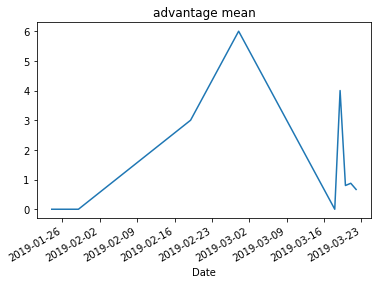

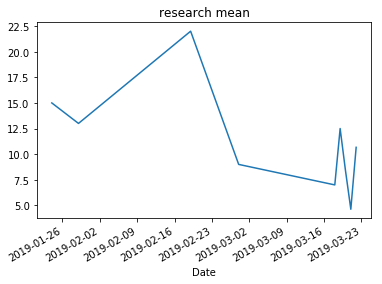

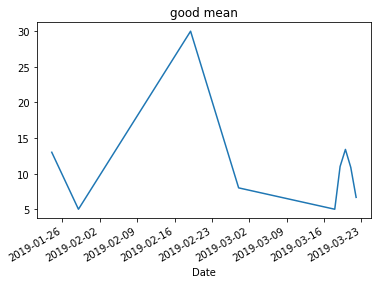

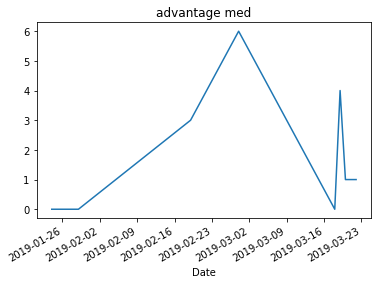

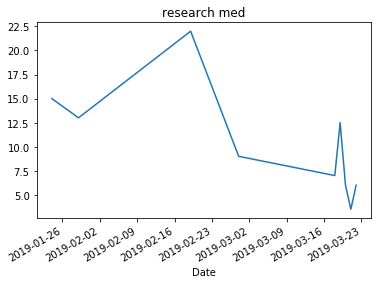

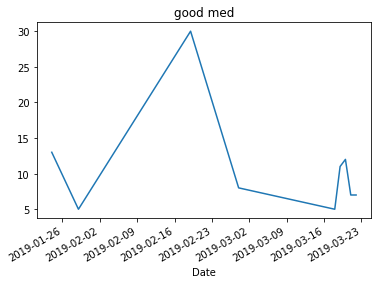

In [45]:
# Regex Plotting
re1mean_df = df.groupby('Date').mean()['re1']
re2mean_df = df.groupby('Date').mean()['re2']
re3mean_df = df.groupby('Date').mean()['re3']

re1med_df = df.groupby('Date').median()['re1']
re2med_df = df.groupby('Date').median()['re2']
re3med_df = df.groupby('Date').median()['re3']

plots = [re1mean_df, re2mean_df, re3mean_df, re1med_df, re2med_df, re3med_df]
reg = [re1+" mean", re2+" mean", re3+" mean", re1+" med", re2+" med", re3+" med"]
for fig in range(len(plots)):
    plt.figure()
    plots[fig].plot()
    plt.title(reg[fig])


In [46]:
# Run a Naive Bayes Classifier to predict the binary variable you developed when creating the CSV file. Which words are most indicative of 1 and which of 0
nb = MultinomialNB()
X = tfidf.values
y = df['Return or not to Return']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(17, 5760)
(6, 5760)
(17,)
(6,)


In [47]:
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [48]:
y_pred_class = nb.predict(X_test)
metrics.accuracy_score(y_test, y_pred_class)

0.5

In [49]:
metrics.confusion_matrix(y_test, y_pred_class,labels=[1,0])

array([[0, 3],
       [0, 3]])

In [50]:
metrics.recall_score(y_test.values, y_pred_class, pos_label=1)

0.0

In [51]:
metrics.precision_score(y_test.values, y_pred_class, pos_label=1)

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0